In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

dataroot = '../WaterLevelPredction_SelectingModel//Data/'

In [2]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

In [3]:
tss = TimeSeriesSplit(n_splits=4, test_size=365)
df = df.sort_index()

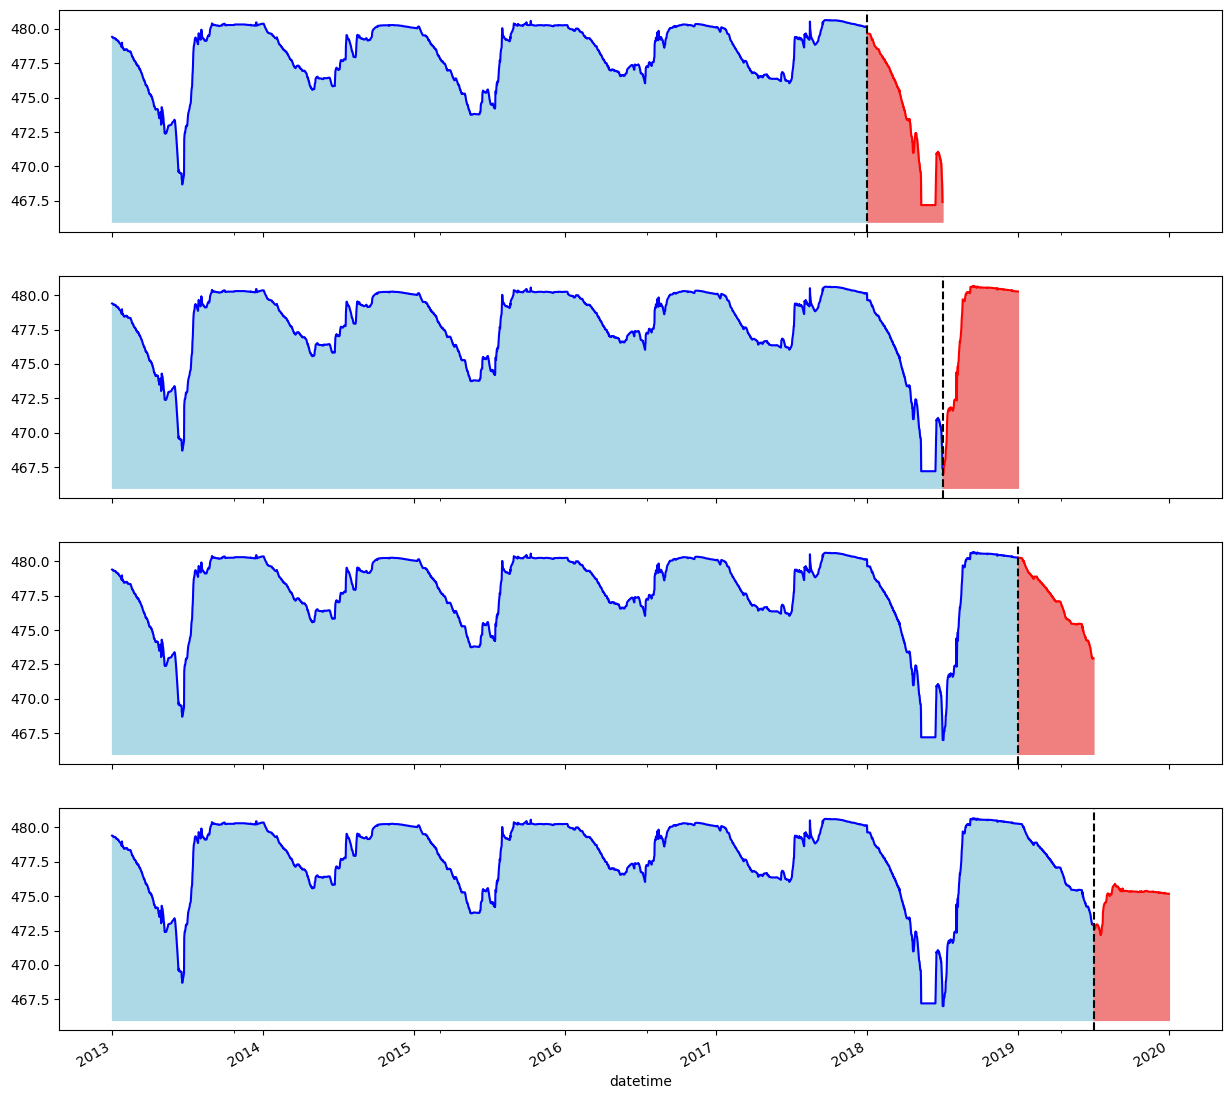

In [4]:
fig, axs = plt.subplots(4,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

In [5]:
#Create Lag Feature
def add_lag(df):
    target_map = df['water_level'].to_dict() #mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)

In [44]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [45]:
xgb_reg = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, 
                           param_grid=param_grid,
                           cv=tss)

In [46]:
features = ['hour','precipitation','sluice_status','lag']
target = 'water_level'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

grid_result = grid_search.fit(X_train, y_train)
grid_result

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=365),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]})

In [47]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


In [48]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100,
                           learning_rate=0.05,
                           booster = 'gbtree',
                           early_stopping_rounds=50,
                           max_depth = 4,
                           colsample_bytree = 1.0,
                           subsample = 0.8
                          )
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:2.03362	validation_1-rmse:6.08983
[1]	validation_0-rmse:1.93413	validation_1-rmse:5.83470
[2]	validation_0-rmse:1.83983	validation_1-rmse:5.59408
[3]	validation_0-rmse:1.75014	validation_1-rmse:5.36523
[4]	validation_0-rmse:1.66536	validation_1-rmse:5.15330
[5]	validation_0-rmse:1.58422	validation_1-rmse:4.94420
[6]	validation_0-rmse:1.50694	validation_1-rmse:4.74611
[7]	validation_0-rmse:1.43379	validation_1-rmse:4.56041
[8]	validation_0-rmse:1.36427	validation_1-rmse:4.38466
[9]	validation_0-rmse:1.29821	validation_1-rmse:4.22337
[10]	validation_0-rmse:1.23545	validation_1-rmse:4.06585
[11]	validation_0-rmse:1.17578	validation_1-rmse:3.91448
[12]	validation_0-rmse:1.11904	validation_1-rmse:3.77565
[13]	validation_0-rmse:1.06533	validation_1-rmse:3.64070
[14]	validation_0-rmse:1.01418	validation_1-rmse:3.51041
[15]	validation_0-rmse:0.96554	validation_1-rmse:3.39261
[16]	validation_0-rmse:0.91951	validation_1-rmse:3.27729
[17]	validation_0-rmse:0.87589	validation

[28]	validation_0-rmse:0.52003	validation_1-rmse:2.31077
[29]	validation_0-rmse:0.49689	validation_1-rmse:2.25787
[30]	validation_0-rmse:0.47497	validation_1-rmse:2.20133
[31]	validation_0-rmse:0.45397	validation_1-rmse:2.14302
[32]	validation_0-rmse:0.43423	validation_1-rmse:2.09209
[33]	validation_0-rmse:0.41531	validation_1-rmse:2.04546
[34]	validation_0-rmse:0.39761	validation_1-rmse:1.99829
[35]	validation_0-rmse:0.38097	validation_1-rmse:1.96074
[36]	validation_0-rmse:0.36496	validation_1-rmse:1.92096
[37]	validation_0-rmse:0.35010	validation_1-rmse:1.87885
[38]	validation_0-rmse:0.33604	validation_1-rmse:1.83863
[39]	validation_0-rmse:0.32317	validation_1-rmse:1.80736
[40]	validation_0-rmse:0.31043	validation_1-rmse:1.77610
[41]	validation_0-rmse:0.29892	validation_1-rmse:1.74141
[42]	validation_0-rmse:0.28804	validation_1-rmse:1.70742
[43]	validation_0-rmse:0.27745	validation_1-rmse:1.67577
[44]	validation_0-rmse:0.26778	validation_1-rmse:1.65036
[45]	validation_0-rmse:0.25892	

In [49]:
print(f'mean squared error across fold:{np.mean(rmse)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(mae)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.07011938102351731
score for each fold:[1.1098944170218743, 0.3117270545170741, 0.05741342674319199, 0.07011938102351731]
mean absolute error across fold:0.04494312192316183
score for each fold:[0.6146667179473472, 0.19561431132277457, 0.03415890544734553, 0.04494312192316183]
r2 score across fold:0.9938168338261348
score for each fold:[0.9316899260193552, 0.9936645738446942, 0.9991282272217532, 0.9938168338261348]


<Figure size 1000x500 with 0 Axes>

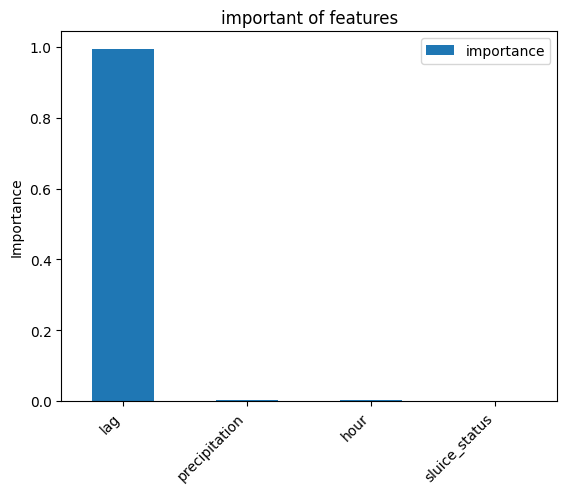

In [50]:
fi = pd.DataFrame(data=xgb_reg.feature_importances_,
              index=xgb_reg.feature_names_in_,
              columns=['importance'])
plt.figure(figsize=(10, 5))
fi = fi.sort_values(by='importance', ascending=False)
fi.plot(kind='bar', legend=True)
plt.title('important of features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

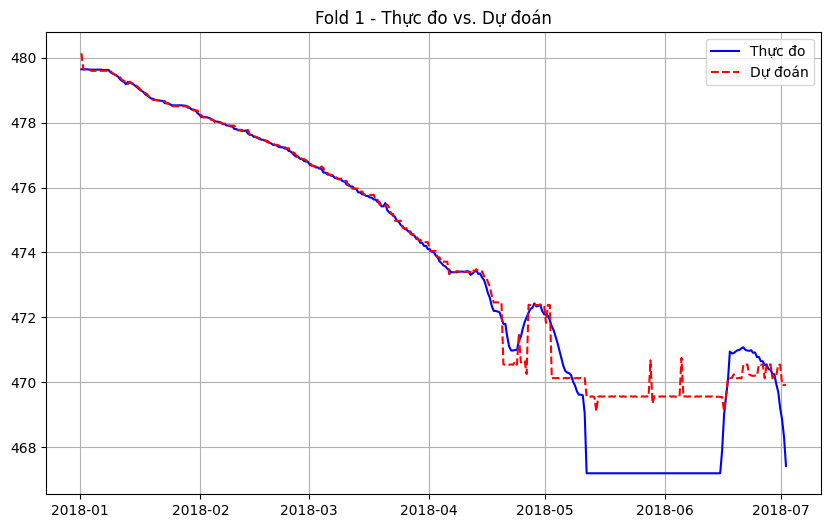

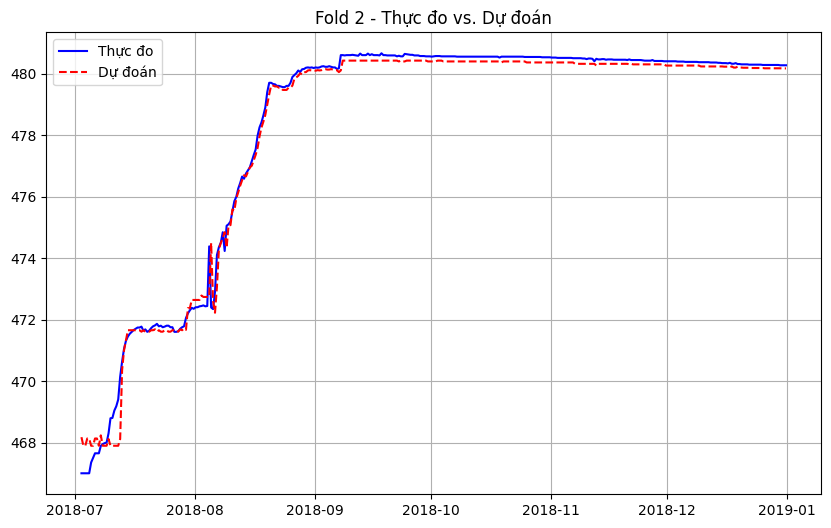

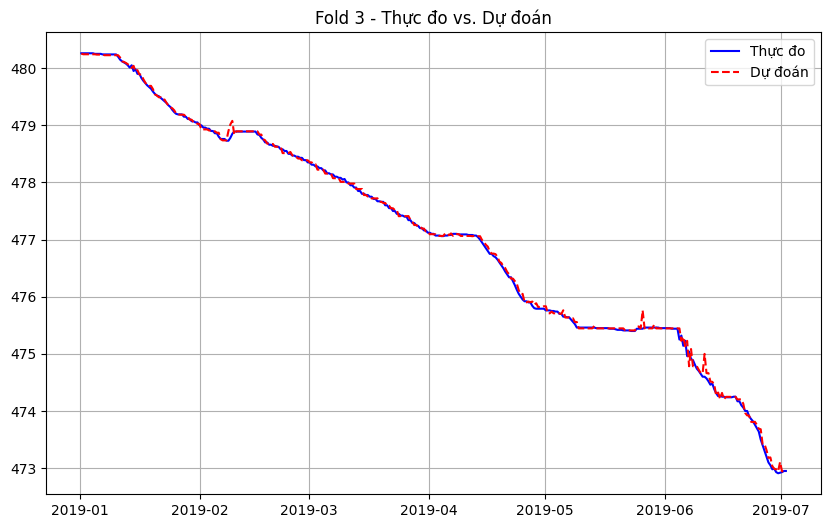

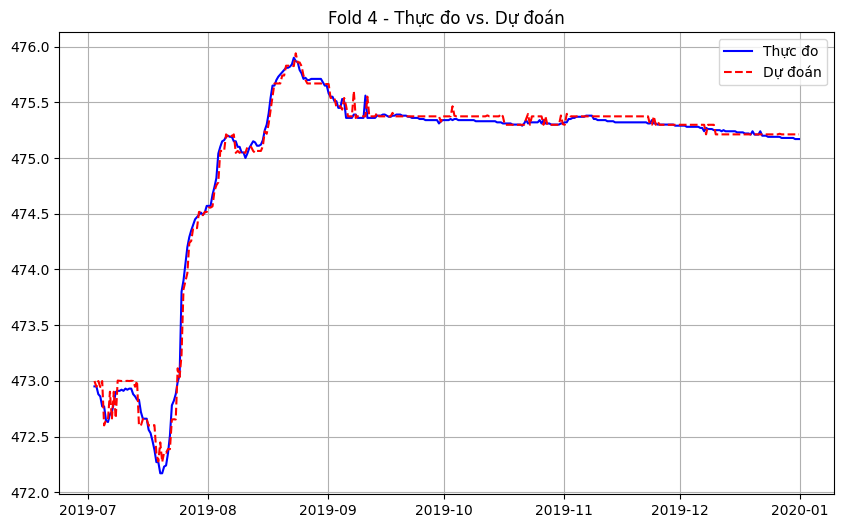

In [51]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()